# Canonical Genetic Algorithm

Implementation of the canonical genetic algorithm to solve the following problem: finding the coefficients of a line in order to find the line that best fits a series of observed points.

After generating the data, I will define a series of functions that will be used to implement parts of the algorithm. This will allow me to verify that these different parts work correctly. With subsequent small modifications, I will finally unify them in the implementation of the complete algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from IPython import display

**Here are the steps to create observations from a line with some noise:**

Remember the equation of a line: $y=a x + b$. 

1. Define the initial coefficients ($a_0$, $b_0$) by choosing values within the interval [-5,5] ($a_0 \in [-5,5]$, $b_0 \in [-5,5]$).
2. Generate 10 points evenly distributed between 1 and 10 and save them in the variable $x$. Assign the corresponding values defined by the line equation to each point.
3. Add Gaussian noise to each point (mean 0, standard deviation 1). These will be your observations ($y_{obs}$ in the mean squared error formula below).
4. Visualize the observations along with the initial line.

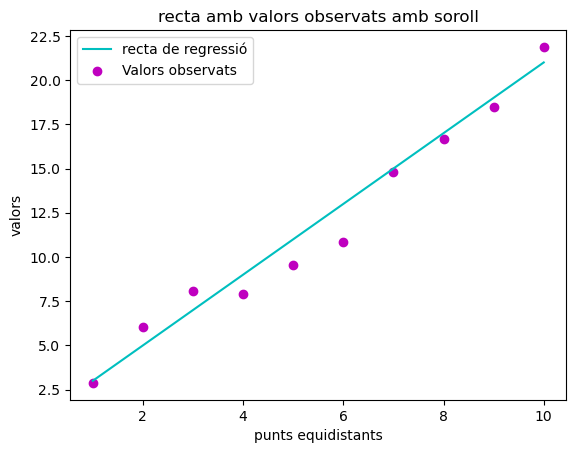

In [3]:
a0 = 2  #valor de a0
b0 = 1  #valor de b0

x = np.arange(1,11,1) #valor distribuits equidistament del 1 al 10 
y = a0*x + b0  #recta ideal
yobs = y + np.random.normal(0,1,10) #punts y amb soroll

#Representació gráfica
plt.plot(x,y,color='c',linestyle='-',label='recta de regressió')
plt.scatter(x,yobs,color='m',label='Valors observats')

plt.xlabel('punts equidistants')
plt.ylabel('valors')
plt.title("recta amb valors observats amb soroll")
plt.legend()
plt.show()

**Creation of the class 'individual'** 

Definition of the function *assign_fitness*, which takes an individual from the Individual class as an argument and assigns the corresponding fitness (1/MSE) to the *fitness* attribute.

Remember the formula of the MSE:

$E=\frac{1}{n}\Sigma_{i=0}^{n-1}(y_{i,obs}-y_{i,pred})^2$

In [6]:
def f_distances (a,b,xvals,yvalssor): #funcio f_distances, calcula la distancia entre les y predides i y observades
    yvals = a*xvals + b #recta ideal
    f_dist = yvals - yvalssor #distancia entre els dos punts
    return f_dist

def get_error (a,b,xvals,yvalssor): #funció get_error
    f_dist = f_distances(a,b,xvals,yvalssor)
    error = []
    for i in f_dist: #recorre el vector de f_dist i eleva al cub cada coponent
        e = i*i 
        error.append(e)
    j = 0
    for i in error: 
        j += i #sumatori de tots els elements del vector 
        E = (1/len(xvals))*j #mitja
    return E

In [7]:
#creació classe individual3 de la pràctica 3
class individual():
    
    def __init__(self, ng=2, gt=np.array([]),ft=0): #definim els atributs de la classe, i el tipus de variable que son
        self.ngenes = int(ng)
        self.genotype = np.array(gt)
        self.fitness = ft
        if len(self.genotype) == 0: #si no hi ha cap valor d'entrada en el genotype, s'entra al metode de set_random_genotype3
            self.genotype = individual.set_random_genotype3 (self.ngenes)
            
    def set_random_genotype3 (ngenes):
        return np.random.normal(0,5,ngenes)

def assign_fitness (indv):
    a = indv.genotype[0]
    b = indv.genotype[1]
    E = get_error(a,b,x,yobs)
    indv.fitness = 1.0/E 

**Mutation**

Define a mutation function called *mutate* that applies Gaussian mutation. For each gene in an individual's genotype, with a probability of *p_mut*, the value can be modified by adding a random number drawn from a normal distribution centered at 0 with a standard deviation of $\sigma$.

In [8]:
def mutate(individual, p_mut, sigma):
    for i in range(len(individual.genotype)):
        if np.random.random() < p_mut:  # determinar si es realitza la mutació pel gen i
            individual.genotype[i] += np.random.normal(0, sigma, 1)  # modificar el valor del gen amb una distribució normal

**Fitness Selection**

Implementation of a function that takes an array of fitness values, not necessarily in order, and selects one of the fitness values using fitness-proportionate selection:

Given the fitness values in ascending order $[f_0, f_1, \cdots, f_{n-1}]$, generate a random number $r \in [0, \sum_{j=0}^{n-1}f_{j}$] and choose the index $k$ such that:

$\sum_{j=0}^{k-1}f_j \le r < \sum_{j=0}^{k}f_j$

In [10]:
def sel_fitness (valors: np.ndarray):
    valors.sort()
    suma = 0
    valors_acumulats = []
    for fi in valors:
        suma += fi
        valors_acumulats.append(suma)
    r = np.random.randint(0, suma+1) #Sumamos +1 porque en la función randint el último número no está incluido
    if r < valors_acumulats[0]:
        print(valors_acumulats[0])
    else:
        for i in range(len(valors_acumulats)-1): 
        # ponemos el -1 porque queremos iterar la lista de valors_acumulats hasta el penúltimo índice porrque la r nunca será 
        # mayor que el el último valor de la variable valors_acumulats
            if r > valors_acumulats[i] and r <= valors_acumulats[i+1]:
                print(valors_acumulats[i+1])

**Selection**

Implementation of the function called *select* that takes as an argument the list of individuals corresponding to the population and returns two different individuals (which will be the parents in the algorithm) based on the fitness proportionate selection process implemented above.

In [11]:
def select (list_indv): #list_indv es una lista con instáncias de individuos de una población de la clase individual()
    list_indv2 = list_indv.copy()
    
    fitness_array = []
    for i in range(len(list_indv2)):
        fitness_array.append(list_indv2[i].fitness)
    
    fitness_array.sort()
    fitness_acumulades = np.cumsum(fitness_array)
    
    index = 0
    r = np.random.uniform (0, fitness_acumulades[-1])
    if r < fitness_acumulades[0]:
        index = 0
    else:
        for i in range(len(fitness_acumulades)-1): 
            if r > fitness_acumulades[i] and r <= fitness_acumulades[i+1]:
                index = i+1
    
    fitness_sel = fitness_array[index]
    for indv in list_indv2:
        if indv.fitness == fitness_sel:
            individu1 = indv
            list_indv2.remove(indv)
    
    
    #Mismo proceso pero con un individuo menos
    fitness_array2 = []
    for i in range(len(list_indv2)):
        fitness_array2.append(list_indv2[i].fitness)
    
    fitness_array2.sort()
    fitness_acumulades2 = np.cumsum(fitness_array2)

    index = 0
    r = np.random.uniform (0, fitness_acumulades2[-1])
    
    if r < fitness_acumulades2[0]:
        index = 0
    else:
        for i in range(len(fitness_acumulades2)-1): 
            if r > fitness_acumulades2[i] and r <= fitness_acumulades2[i+1]:
                index = i+1
    
    fitness_sel2 = fitness_array2[index]
    for indv in list_indv2:
        if indv.fitness == fitness_sel2:
            individu2 = indv
            
            
    return (individu1, individu2)

**Crossover**


Implement the function *mate* that takes three arguments: two parents ( $p_1$, $p_2$ ) and $\eta$, and returns two offspring  ($f_1$, $f_2$). The genotypes of the offspring are determined using the simulated binary crossover method:
$$
f_1=(1/2)[(1+\beta)p_1 + (1-\beta)p_2]\\
f_2=(1/2)[(1-\beta)p_1 + (1+\beta)p_2]
$$

Where $\beta$ is chosen from:
$$
\beta=\begin{cases}
(2u)^{\frac{1}{\eta+1}}, & \text{if } u \leq 0.5\\
\frac{1}{2(1-u)}^{\frac{1}{\eta+1}}, &\text{if } u > 0.5 \\
\end{cases}
$$

and $u$ is a random number between [0,1] and $\eta$ is the crowding factor.

In [12]:
def mate (pare1, pare2, nu): #p1 y p2 son los genotipos de los padres
    p1 = pare1.genotype
    p2 = pare2.genotype
    f1 = individual(3, [0,0,0])
    f2 = individual(3, [0,0,0])
    u = np.random.uniform(0,1)
    if u <= 0.5:
        beta = pow(2*u, 1/(nu+1)) # nu = crowding factor
    else:
        beta = pow(2*(1-u), 1/(nu+1))
    
    #simulated binary crossover
    f1.genotype = (1/2) * ((1+beta)*p1 + (1-beta)*p2)
    f2.genotype = (1/2) * ((1-beta)*p1 + (1+beta)*p2)
    return (f1,f2)

**Final genetic algorithm**

The function ensures that the best individual of each generation always passes to the next one. The probability of crossover between two parents is p_crossover, and the mutation of each offspring after crossover is executed only with a probability of p_mut_ind. At the end we it is observed a grafic od the mean an maximun fitness for each iteration of the algorithm.

In [13]:
def algorisme (pobl, p_crossover, nu, p_mut_ind, p_mut, sigma):
    f_media = [] #Lista donde guardaremos la fitness media de cada iteración del algoritmo
    f_max = [] #Lista donde guardaremos la fitness máxima de cada iteración del algoritmo
    
    for indv in pobl:
            assign_fitness(indv) #Asignamos una fitness a cada individuo de la población inicial
    
    for i in range(1000): #iteramos el algoritmo 100 veces          
        pobl_fills = []

        while len(pobl_fills) < len(pobl): #Substituimos toda la población de los padres con el mismo número de hijos
            pares = select(pobl) #Seleccionamos dos individuos para que sean los padres
            pare1 = pares[0]
            pare2 = pares[1]

            u = np.random.uniform(0,1)
            if u <= p_crossover: #p_crossover = probabilitat de crossover entre dos pares
                fills = mate(pare1, pare2, nu) #Crossover entre los padres seleccionados para conseguir dos hijos
                fill1 = fills[0]
                fill2 = fills[1]
                
                u2 = np.random.uniform(0,1)
                if u2 <= p_mut_ind: #p_mut_ind = probabilitiat de mutació de cada fill després del crossover
                    mutate(fill1, p_mut, sigma) #Si se supera p_mut_ind, se muta cada indivuduo y cada gen de 
                    mutate(fill2, p_mut, sigma) #su genotipo muta con probabilidad p_mut
                
                #Añadimos los dos individuos hijos tanto si han mutado como no 
                pobl_fills.append(fill1) 
                pobl_fills.append(fill2)
                
            else: #Si no hay crossover los dos hijos son iguales que los padres y pasan a la siguiente generación
                pobl_fills.append(pare1)
                pobl_fills.append(pare2)
        
        pobl = pobl_fills #La nueva población creada de hijos substituye a la de los padres e iteramos otra vez
        
        for indv in pobl:
            assign_fitness(indv) #Asignamos una fitness a cada individuo de la población nueva
        
        fitness = []
        for indv in pobl:
            fitness.append(indv.fitness) #Guardamos todas las fitness en una lista
        f_media.append(np.mean(fitness))
        f_max.append(max(fitness))
        
    return (pobl, f_media, f_max)

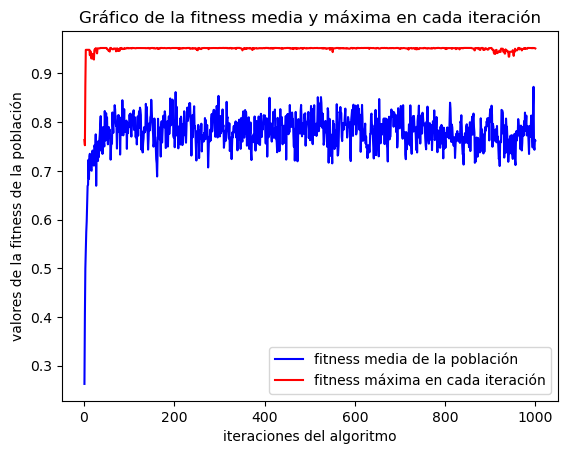

In [14]:
poblacion = []
for i in range(100): #Creamos 100 individuos con genotipos creados por la función set_random_genotype3 para nuestra población 
    ind = individual(2) #Los genotipos tendrán 2 genes
    poblacion.append(ind)

datos = algorisme (poblacion, 0.5, 0.2, 0.7, 0.5, 0.3) # p_crossover = 1, nu = 0.2, p_mut_ind = 0.7, p_mut = 0.5, sigma = 0.3
pobl_final = datos[0] #La última generación de la población
fit_med =  datos[1]
fit_max =  datos[2]

valx = np.arange(1,1001,1) #Vector que contiene el número de iteraciones que hayamos ejecutado el algoritmo
plt.plot(valx,fit_med,color='b',label='fitness media de la población')
plt.plot(valx,fit_max,color='r',label='fitness máxima en cada iteración')
plt.xlabel('iteraciones del algoritmo')
plt.ylabel('valores de la fitness de la población')
plt.title('Gráfico de la fitness media y máxima en cada iteración')
plt.legend()
plt.show()


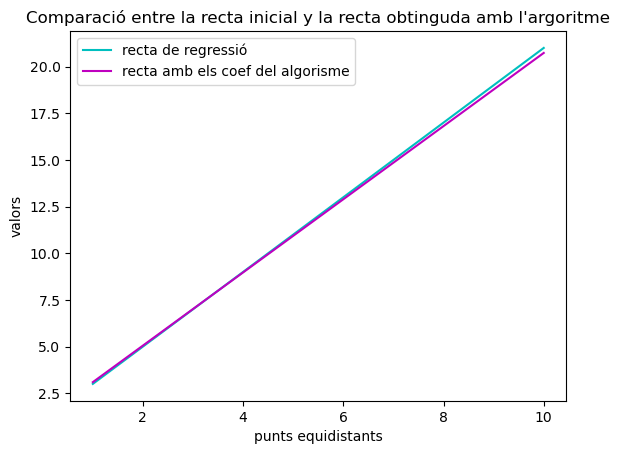

In [15]:
ind1 = pobl_final[0]
af = ind1.genotype[0]
bf = ind1.genotype[1]
yf = af*x + bf

plt.plot(x,y,color='c',linestyle='-',label='recta de regressió')
plt.plot(x,yf,color='m',linestyle='-',label='recta amb els coef del algorisme')

plt.xlabel('punts equidistants')
plt.ylabel('valors')
plt.title("Comparació entre la recta inicial y la recta obtinguda amb l'argoritme")
plt.legend()
plt.show()